<a href="https://colab.research.google.com/github/MakowToms/DeepLearning/blob/main/cnn/from_kaggle_in_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The CIFAR first steps. The following notebook is based on code from kaggle platform:
https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer


# Data preparation

In [19]:
!pip install tensorflow-determinism
!pip install natsort

In [20]:
from __future__ import print_function
import os
import pickle
import random

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
os.environ['TF_DETERMINISTIC_OPS'] = '1' # credits Wojciech Bogucki

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split 
import pandas as pd
from natsort import natsorted
import itertools

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 263940591258548764
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12420788866024737913
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [21]:
def set_seed(seed=123):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
  
set_seed()

In [22]:
# Set global variables
batch_size = 32  # The default batch size of keras
num_classes = 10  # Number of class for the dataset
epochs = 100
n = 5
data_augmentation = False

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [23]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

# Normalize the data. Before we need to connvert data type to float for computation
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Split train-validation dataset
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=123)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')
print(y_val[:10].sum(axis=0) + y_test[:10].sum(axis=0) + y_train[:10].sum(axis=0))

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
45000 train samples
5000 validation samples
10000 test samples
[4. 6. 3. 2. 1. 1. 6. 2. 5. 0.]


## Define functions, optimizers and models

In [24]:
# Train exact model many times and get mean results

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()


def results_of_model(model, opt, opt_name, n=10, plot=False, 
                     data_augmentation=False, 
                     shift=0.1, horizontal_flip=True, rotation=10, workers=4,
                     early_stopping=early_stopping):
    histories = []
    for i in range(n):
        print(f'\n\nModel {i}:')
        set_seed(i+2)

        model = tf.keras.models.clone_model(model)
        model.compile(loss='categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])

        if not data_augmentation:
          history = model.fit(x_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(x_val, y_val),
                              callbacks = [early_stopping],
                              shuffle=True)
        else:
          datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=rotation,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=shift,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=shift,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=horizontal_flip,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

          # Compute quantities required for feature-wise normalization
          # (std, mean, and principal components if ZCA whitening is applied).
          datagen.fit(x_train)

          # Fit the model on the batches generated by datagen.flow().
          history = model.fit_generator(datagen.flow(x_train, y_train,
                                        batch_size=batch_size),
                                        epochs=epochs,
                                        validation_data=(x_val, y_val),
                                        callbacks = [early_stopping],
                                        workers=workers)

        histories.append((
            history.history['accuracy'],
            history.history['val_accuracy'],
            history.history['loss'],
            history.history['val_loss']
        ))
        if plot:
            plotmodelhistory(history)

    if not data_augmentation:
      with open(f'drive/MyDrive/Colab Notebooks/pickles/{model.name}-{opt_name}', 'wb') as f:
        pickle.dump(histories, f)
    else:
      with open(f'drive/MyDrive/Colab Notebooks/aug/{model.name}-{opt_name}-{shift}-{horizontal_flip}-{rotation}-{early_stopping.patience}', 'wb') as f:
        pickle.dump(histories, f)


    model = None
    tf.keras.backend.clear_session()

    return histories

In [25]:
tf.keras.backend.clear_session()

set_seed(123)

optimizers = [
        (keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6), 'RMSProp'),
        (keras.optimizers.Adam(learning_rate=0.001), 'Adam')
]

# Train first models


## 2 Conv Blocks

### Basic 2 Conv Blocks

In [ ]:
set_seed(123)
#define the model - convolution network
model = Sequential(name='2ConvBlocks_smaller_padding')
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

for opt in optimizers:
    results_of_model(model, opt[0], opt[1], n=n)
    print(f'Ended optimizer {opt[1]} \n\n\n\n')

Model: "2ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15,

### 2 Conv Blocks without smaller padding (same padding)

In [ ]:
set_seed(123)
model = Sequential(name='2ConvBlocks_same_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

for opt in optimizers:
    results_of_model(model, opt[0], opt[1], n=n)
    print(f'Ended optimizer {opt[1]} \n\n\n\n')

Model: "2ConvBlocks_same_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16

## 3 Conv Blocks

### 3 Conv Blocks

In [ ]:
set_seed(123)
model = Sequential(name='3ConvBlocks_same_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

for opt in optimizers:
    results_of_model(model, opt[0], opt[1], n=n)
    print(f'Ended optimizer {opt[1]} \n\n\n\n')

Model: "3ConvBlocks_same_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16

### 3 Conv Blocks with smaller padding

In [ ]:
set_seed(123)
model = Sequential(name='3ConvBlocks_smaller_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

for opt in optimizers:
    results_of_model(model, opt[0], opt[1], n=n)
    print(f'Ended optimizer {opt[1]} \n\n\n\n')

Model: "3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15,

### Bigger 3 Conv Blocks with same padding

In terms of more "hidden" layers (the layers of third dimension is bigger and bigger)
And also more dense layers (one more with 1024 neurons)

In [ ]:
set_seed(123)
model = Sequential(name='Bigger_3ConvBlocks_same_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

for opt in optimizers:
    results_of_model(model, opt[0], opt[1], n=n)
    print(f'Ended optimizer {opt[1]} \n\n\n\n')

Model: "Bigger_3ConvBlocks_same_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None,

### Bigger (CNN) 3 Conv Blocks with same padding

In terms of more "hidden" layers (the layers of third dimension is bigger and bigger)

In [ ]:
set_seed(123)
model = Sequential(name='Bigger_CNN_3ConvBlocks_same_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

for opt in optimizers[:1]:
    results_of_model(model, opt[0], opt[1], n=1)
    print(f'Ended optimizer {opt[1]} \n\n\n\n')

Model: "Bigger_CNN_3ConvBlocks_same_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (N

### Bigger (CNN) 3 Conv Blocks with smaller padding

In terms of more "hidden" layers (the layers of third dimension is bigger and bigger)

In [ ]:
set_seed(123)
model = Sequential(name='Bigger_CNN_3ConvBlocks_smaller_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

for opt in optimizers[:1]:
    results_of_model(model, opt[0], opt[1], n=3)
    print(f'Ended optimizer {opt[1]} \n\n\n\n')

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

### Bigger 3 Conv Blocks with smaller padding

In terms of more "hidden" layers (the layers of third dimension is bigger and bigger)
And also more dense layers (one more with 1024 neurons)

In [ ]:
set_seed(123)
model = Sequential(name='Bigger_3ConvBlocks_smaller_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

for opt in optimizers[:1]:
    results_of_model(model, opt[0], opt[1], n=1)
    print(f'Ended optimizer {opt[1]} \n\n\n\n')

Model: "Bigger_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (No

## 4 Conv Blocks

### 4 Conv Blocks smaller padding

Padding in the last conv block have to be same because of negative result shape

In [ ]:
set_seed(123)
model = Sequential(name='4ConvBlocks_smaller_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

for opt in optimizers[:1]:
    results_of_model(model, opt[0], opt[1], n=1)
    print(f'Ended optimizer {opt[1]} \n\n\n\n')

Model: "4ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15,

### 4 Conv Blocks same padding


In [ ]:
set_seed(123)
model = Sequential(name='4ConvBlocks_same_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

for opt in optimizers[:1]:
    results_of_model(model, opt[0], opt[1], n=1)
    print(f'Ended optimizer {opt[1]} \n\n\n\n')

Model: "4ConvBlocks_same_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16

## Plots of models


2CB RMSProp
Accuracy 0.7572 \pm 0.0111
Loss 0.7116 \pm 0.0281
2CB_padding RMSProp
Accuracy 0.7522 \pm 0.0084
Loss 0.7342 \pm 0.0267
3CB_padding RMSProp
Accuracy 0.8041 \pm 0.0069
Loss 0.5797 \pm 0.0171
3CB RMSProp
Accuracy 0.7881 \pm 0.0121
Loss 0.6240 \pm 0.0293
channel++_dense++_3CB_padding RMSProp
Accuracy 0.8051 \pm 0.0053
Loss 0.6042 \pm 0.0153
channel++_dense++_3CB RMSProp
Accuracy 0.7754 \pm 0.0000
Loss 0.6395 \pm 0.0000
4CB RMSProp
Accuracy 0.8020 \pm 0.0000
Loss 0.5974 \pm 0.0000
4CB_padding RMSProp
Accuracy 0.8004 \pm 0.0000
Loss 0.6350 \pm 0.0000
channel++_3CB_padding RMSProp
Accuracy 0.8122 \pm 0.0000
Loss 0.5737 \pm 0.0000
channel++_3CB RMSProp
Accuracy 0.8127 \pm 0.0134
Loss 0.5698 \pm 0.0272
2CB Adam
Accuracy 0.3646 \pm 0.3221
Loss 1.6639 \pm 0.7825
2CB_padding Adam
Accuracy 0.2322 \pm 0.2663
Loss 1.9769 \pm 0.6516
3CB_padding Adam
Accuracy 0.2356 \pm 0.2681
Loss 1.9736 \pm 0.6580
3CB Adam
Accuracy 0.2333 \pm 0.2636
Loss 1.9826 \pm 0.6400
channel++_dense++_3CB_padding Ad

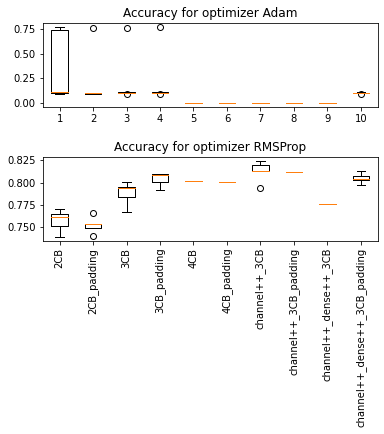

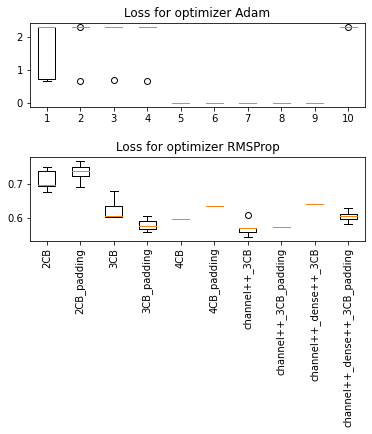

In [12]:
directory = 'drive/MyDrive/Colab Notebooks/pickles/'
files = os.listdir(directory)
files_Adam = [file for file in files[1:] if file.split('-')[1]=='Adam']
files_RMSProp = [file for file in files[1:] if file.split('-')[1]=='RMSProp']
all_files = [files_RMSProp, files_Adam]

acc = {'Adam': {}, 'RMSProp': {}}   #1
loss = {'Adam': {}, 'RMSProp': {}}  #3
for file_list in all_files:
  for filename in file_list:
    model_name = filename.split('-')[0]
    model_name = model_name.replace('ConvBlocks', 'CB')
    model_name = model_name.replace('same_padding', 'padding')
    model_name = model_name.replace('_smaller_padding', '')
    model_name = model_name.replace('Bigger_CNN', 'channel++')
    model_name = model_name.replace('Bigger', 'channel++_dense++')
    opt_name = filename.split('-')[1]
    with open(directory + filename, 'rb') as f:
      history = pickle.load(f)
      a = []
      l = []
      for i in range(len(history)):
        a.append(history[i][1][-6])
        l.append(history[i][3][-6])
      print(model_name, opt_name)
      print(f'Accuracy {np.mean(np.array(a)):0.04f} \pm {np.std(np.array(a)):0.04f}')
      print(f'Loss {np.mean(np.array(l)):0.04f} \pm {np.std(np.array(l)):0.04f}')
      if len(a) < n:
        # if too few samples - append samples with mean
        a = a + [sum(a)/len(a)] * (n - len(a))
        l = l + [sum(l)/len(l)] * (n - len(l))
        acc['Adam'][model_name] = [0] * n
        loss['Adam'][model_name] = [0] * n
      acc[opt_name][model_name] = a
      loss[opt_name][model_name] = l

measures = [acc, loss]
measure_names = ['Accuracy', 'Loss']
for index in range(2):
  plt.subplots(2, 1)
  plt.subplots_adjust(hspace=0.6)
  for i, opt_name in enumerate(acc.keys()):
    plt.subplot(2, 1, i+1)
    data = measures[index][opt_name]
    data = pd.DataFrame(data)    
    data = data.reindex(natsorted(data.columns), axis=1)
    labels = data.columns
    plt.boxplot(np.array(data))
    plt.title(f'{measure_names[index]} for optimizer {opt_name}')
  ax = plt.gca()
  ax.set_xticklabels(labels=labels, rotation=90)
  plt.show()

# plt.savefig("plots/activations/{0}_{1}_loss_boxplot.png".format(dataset.name, dataset.size),
#             dpi=100, bbox_inches="tight")

# Data augmentation

## Model 1

In [26]:
opt = optimizers[0]
data_augmentation = True

set_seed(123)
model = Sequential(name='Bigger_CNN_3ConvBlocks_smaller_padding')
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Shift=0.05, Flip=True

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 35s 24ms/step - loss: 2.0999 - accuracy: 0.2007 - val_loss: 1.6417 - val_accuracy: 0.3980
Epoch 2/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.6490 - accuracy: 0.3907 - val_loss: 1.4452 - val_accuracy: 0.4754
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.4593 - accuracy: 0.4679 - val_loss: 1.3221 - val_accuracy: 0.5322
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.3251 - accuracy: 0.5194 - val_loss: 1.1777 - val_accuracy: 0.5770
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.2348 - accuracy: 0.5553 - val_loss: 1.3104 - val_accuracy: 0.5418
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.1494 - accuracy: 0.5881 - val_loss: 1.0368 - val_accuracy: 0.6442
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.0824 - accuracy: 0.6185 - val_loss: 1

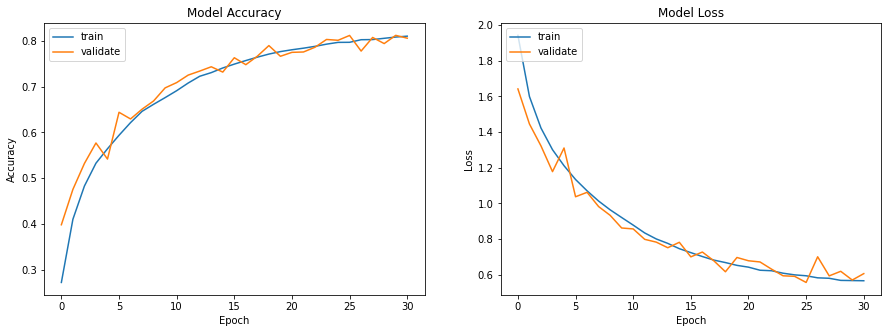

[([0.2717111110687256,
   0.4099777638912201,
   0.4828000068664551,
   0.5327555537223816,
   0.5643555521965027,
   0.593844473361969,
   0.621577799320221,
   0.6462888717651367,
   0.6616888642311096,
   0.6763111352920532,
   0.691444456577301,
   0.7082444429397583,
   0.7230444550514221,
   0.7310000061988831,
   0.7411999702453613,
   0.7496444582939148,
   0.757444441318512,
   0.7648666501045227,
   0.7716000080108643,
   0.777044415473938,
   0.7810666561126709,
   0.7845333218574524,
   0.7885110974311829,
   0.7933333516120911,
   0.7972221970558167,
   0.7973777651786804,
   0.8030444383621216,
   0.8033778071403503,
   0.8061333298683167,
   0.8088666796684265,
   0.81086665391922],
  [0.39800000190734863,
   0.47540000081062317,
   0.5321999788284302,
   0.5770000219345093,
   0.5418000221252441,
   0.6442000269889832,
   0.6295999884605408,
   0.6510000228881836,
   0.6690000295639038,
   0.6976000070571899,
   0.7092000246047974,
   0.725600004196167,
   0.73439997434

In [ ]:
shift = 0.05
horizontal_flip = True
rotation = 0
workers = 4
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


### Shift=0.05, Flip=True, rotation=10, patience=5

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 36s 25ms/step - loss: 2.0979 - accuracy: 0.2039 - val_loss: 1.6430 - val_accuracy: 0.3946
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.6388 - accuracy: 0.3963 - val_loss: 1.4115 - val_accuracy: 0.4894
Epoch 3/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.4580 - accuracy: 0.4707 - val_loss: 1.3881 - val_accuracy: 0.5064
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.3274 - accuracy: 0.5184 - val_loss: 1.2082 - val_accuracy: 0.5624
Epoch 5/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.2294 - accuracy: 0.5625 - val_loss: 1.2076 - val_accuracy: 0.5782
Epoch 6/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.1501 - accuracy: 0.5914 - val_loss: 1.0266 - val_accuracy: 0.6314
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.0781 - accuracy: 0.6163 - val_loss: 1

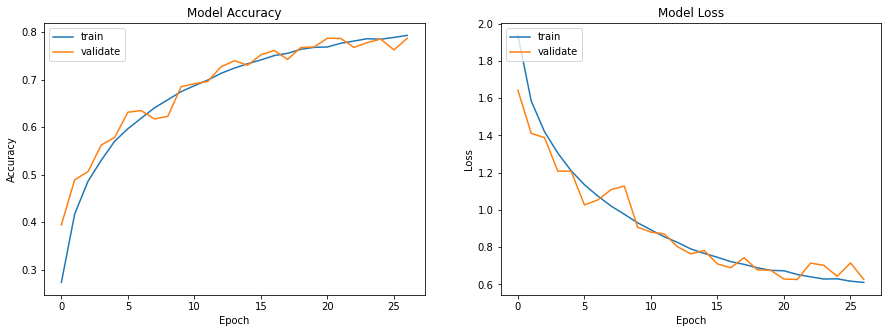

[([0.27355554699897766,
   0.4172666668891907,
   0.48604443669319153,
   0.5304444432258606,
   0.5701777935028076,
   0.5966444611549377,
   0.618755578994751,
   0.6405777931213379,
   0.6574888825416565,
   0.6746222376823425,
   0.6870889067649841,
   0.6988444328308105,
   0.7130444645881653,
   0.7240222096443176,
   0.7331555485725403,
   0.7412444353103638,
   0.7503555417060852,
   0.755133330821991,
   0.7635555267333984,
   0.7676666378974915,
   0.7684666514396667,
   0.7762444615364075,
   0.7809555530548096,
   0.7858889102935791,
   0.7847333550453186,
   0.7885333299636841,
   0.7929111123085022],
  [0.3946000039577484,
   0.4893999993801117,
   0.5063999891281128,
   0.5623999834060669,
   0.5781999826431274,
   0.6313999891281128,
   0.6348000168800354,
   0.6172000169754028,
   0.6226000189781189,
   0.6850000023841858,
   0.6912000179290771,
   0.6959999799728394,
   0.7268000245094299,
   0.7396000027656555,
   0.7301999926567078,
   0.7519999742507935,
   0.76120

In [ ]:
shift = 0.05
horizontal_flip = True
rotation = 10
workers = 2  # just to check if time is different
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


### Shift=0.05, Flip=True, rotation=10, patience=10

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 71s 27ms/step - loss: 2.1015 - accuracy: 0.2029 - val_loss: 1.6472 - val_accuracy: 0.3962
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.6416 - accuracy: 0.3934 - val_loss: 1.4489 - val_accuracy: 0.4682
Epoch 3/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.4620 - accuracy: 0.4679 - val_loss: 1.3419 - val_accuracy: 0.5160
Epoch 4/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.3267 - accuracy: 0.5223 - val_loss: 1.2043 - val_accuracy: 0.5690
Epoch 5/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.2283 - accuracy: 0.5602 - val_loss: 1.2319 - val_accuracy: 0.5744
Epoch 6/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.1520 - accuracy: 0.5924 - val_loss: 1.0576 - val_accuracy: 0.6180
Epoch 7/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.0831 - accuracy: 0.6177 - val_loss: 1

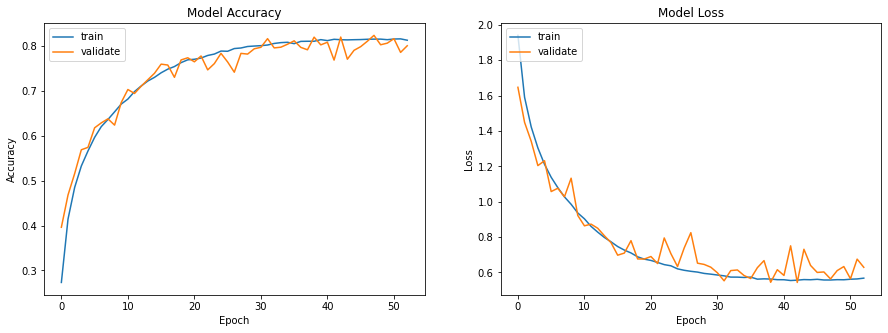

[([0.27308890223503113,
   0.4144666790962219,
   0.4851111173629761,
   0.5327777862548828,
   0.5662888884544373,
   0.596666693687439,
   0.6206444501876831,
   0.6365333199501038,
   0.6535999774932861,
   0.6709111332893372,
   0.6820889115333557,
   0.6988666653633118,
   0.7112666964530945,
   0.7223555445671082,
   0.7305333614349365,
   0.7407333254814148,
   0.7488444447517395,
   0.754622220993042,
   0.7634000182151794,
   0.7696222066879272,
   0.7708444595336914,
   0.7736222147941589,
   0.7793111205101013,
   0.7824666500091553,
   0.7891555428504944,
   0.7886888980865479,
   0.7947555780410767,
   0.7960222363471985,
   0.7993555665016174,
   0.8003555536270142,
   0.8012222051620483,
   0.8026444315910339,
   0.8061333298683167,
   0.8079777956008911,
   0.8087555766105652,
   0.8056666851043701,
   0.8107555508613586,
   0.8110222220420837,
   0.8109999895095825,
   0.814644455909729,
   0.8125110864639282,
   0.8154000043869019,
   0.814466655254364,
   0.814088881

In [ ]:
shift = 0.05
horizontal_flip = True
rotation = 10
workers = 4
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


### Shift=0.05, Flip=False, patience=5

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 38s 26ms/step - loss: 2.1036 - accuracy: 0.2027 - val_loss: 1.6654 - val_accuracy: 0.3884
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.6405 - accuracy: 0.3949 - val_loss: 1.4519 - val_accuracy: 0.4682
Epoch 3/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.4539 - accuracy: 0.4705 - val_loss: 1.3279 - val_accuracy: 0.5294
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.3162 - accuracy: 0.5248 - val_loss: 1.1608 - val_accuracy: 0.5808
Epoch 5/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.2268 - accuracy: 0.5614 - val_loss: 1.2866 - val_accuracy: 0.5442
Epoch 6/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.1402 - accuracy: 0.5965 - val_loss: 1.0552 - val_accuracy: 0.6328
Epoch 7/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.0697 - accuracy: 0.6216 - val_loss: 1

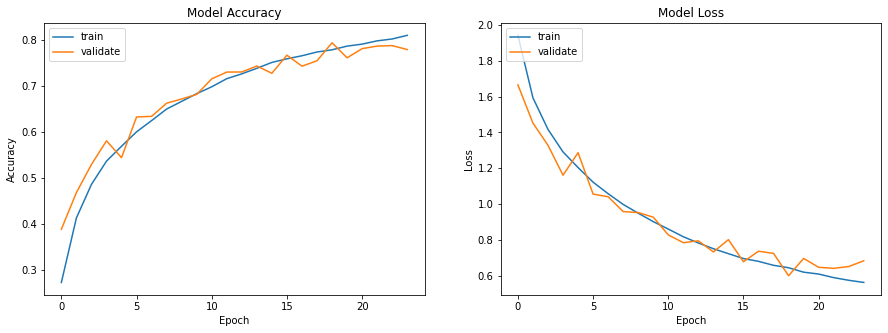

[([0.27248889207839966,
   0.41297778487205505,
   0.4859555661678314,
   0.5365777611732483,
   0.5690444707870483,
   0.6004444360733032,
   0.6249111294746399,
   0.650088906288147,
   0.6667555570602417,
   0.683555543422699,
   0.6985555291175842,
   0.7161999940872192,
   0.7267333269119263,
   0.7387999892234802,
   0.7516000270843506,
   0.759422242641449,
   0.7661111354827881,
   0.7742888927459717,
   0.7790889143943787,
   0.7870888710021973,
   0.7914444208145142,
   0.7985333204269409,
   0.8026444315910339,
   0.810533344745636],
  [0.38839998841285706,
   0.4681999981403351,
   0.5293999910354614,
   0.5807999968528748,
   0.5442000031471252,
   0.6327999830245972,
   0.6341999769210815,
   0.6628000140190125,
   0.671999990940094,
   0.6819999814033508,
   0.7157999873161316,
   0.7305999994277954,
   0.7307999730110168,
   0.7437999844551086,
   0.7279999852180481,
   0.7674000263214111,
   0.743399977684021,
   0.7552000284194946,
   0.7943999767303467,
   0.76160001

In [ ]:
shift = 0.05
horizontal_flip = False
rotation = 0
workers = 4
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


### Shift=0.05, Flip=False, rotation=10, patience=5

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 39s 27ms/step - loss: 2.0954 - accuracy: 0.2031 - val_loss: 1.6733 - val_accuracy: 0.3882
Epoch 2/100
1407/1407 [==============================] - 37s 27ms/step - loss: 1.6392 - accuracy: 0.3940 - val_loss: 1.4081 - val_accuracy: 0.4902
Epoch 3/100
1407/1407 [==============================] - 37s 27ms/step - loss: 1.4578 - accuracy: 0.4703 - val_loss: 1.4375 - val_accuracy: 0.4944
Epoch 4/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.3213 - accuracy: 0.5218 - val_loss: 1.1772 - val_accuracy: 0.5772
Epoch 5/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.2293 - accuracy: 0.5604 - val_loss: 1.1861 - val_accuracy: 0.5828
Epoch 6/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.1422 - accuracy: 0.5951 - val_loss: 1.0407 - val_accuracy: 0.6254
Epoch 7/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.0725 - accuracy: 0.6167 - val_loss: 1

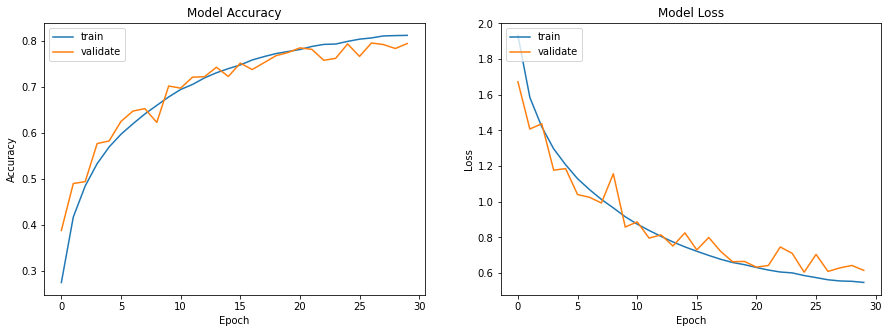

[([0.27497777342796326,
   0.4173111021518707,
   0.48500001430511475,
   0.5334222316741943,
   0.5695777535438538,
   0.5974888801574707,
   0.6201555728912354,
   0.6414889097213745,
   0.6602444648742676,
   0.678600013256073,
   0.6948444247245789,
   0.705822229385376,
   0.7200444340705872,
   0.7311999797821045,
   0.7401999831199646,
   0.7482222318649292,
   0.7590444684028625,
   0.7664444446563721,
   0.7730444669723511,
   0.7774222493171692,
   0.7818222045898438,
   0.7884666919708252,
   0.7929111123085022,
   0.7937333583831787,
   0.79948890209198,
   0.8043333292007446,
   0.807022213935852,
   0.8113333582878113,
   0.8121111392974854,
   0.8126222491264343],
  [0.3882000148296356,
   0.490200012922287,
   0.4943999946117401,
   0.5771999955177307,
   0.5827999711036682,
   0.6254000067710876,
   0.6478000283241272,
   0.6531999707221985,
   0.623199999332428,
   0.7024000287055969,
   0.6977999806404114,
   0.7215999960899353,
   0.722599983215332,
   0.74320000410

In [ ]:
shift = 0.05
horizontal_flip = False
rotation = 10
workers = 4
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


### Shift=0.1, Flip=False, patience=5

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 37s 26ms/step - loss: 2.1033 - accuracy: 0.2016 - val_loss: 1.6314 - val_accuracy: 0.3950
Epoch 2/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.6632 - accuracy: 0.3840 - val_loss: 1.4361 - val_accuracy: 0.4772
Epoch 3/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.4820 - accuracy: 0.4588 - val_loss: 1.2926 - val_accuracy: 0.5404
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.3532 - accuracy: 0.5098 - val_loss: 1.1892 - val_accuracy: 0.5632
Epoch 5/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.2676 - accuracy: 0.5463 - val_loss: 1.2723 - val_accuracy: 0.5476
Epoch 6/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.1829 - accuracy: 0.5776 - val_loss: 1.0878 - val_accuracy: 0.6240
Epoch 7/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.1146 - accuracy: 0.6060 - val_loss: 1

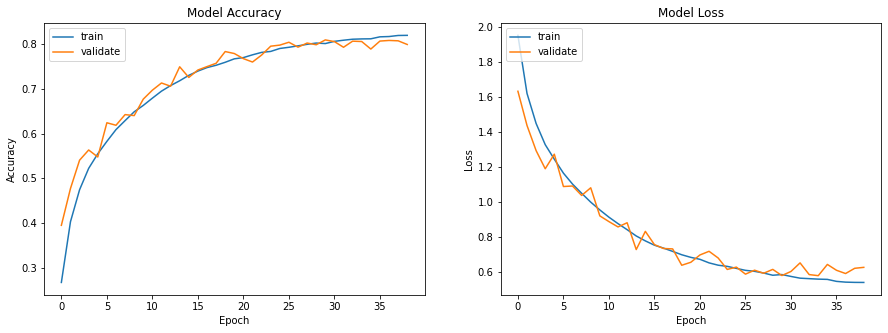

[([0.26742222905158997,
   0.40297776460647583,
   0.4743777811527252,
   0.5221999883651733,
   0.5547555685043335,
   0.5824221968650818,
   0.6086888909339905,
   0.6287555694580078,
   0.6484666466712952,
   0.6627333164215088,
   0.6789555549621582,
   0.694599986076355,
   0.7070000171661377,
   0.7178000211715698,
   0.7298666834831238,
   0.7393555641174316,
   0.74717777967453,
   0.7523777484893799,
   0.7590444684028625,
   0.7667333483695984,
   0.7695333361625671,
   0.7757111191749573,
   0.7811333537101746,
   0.783311128616333,
   0.7898889183998108,
   0.7925333380699158,
   0.7957555651664734,
   0.7991555333137512,
   0.8019777536392212,
   0.8008444309234619,
   0.8057777881622314,
   0.8083333373069763,
   0.810533344745636,
   0.8112221956253052,
   0.8114666938781738,
   0.8158888816833496,
   0.8165333271026611,
   0.8189111351966858,
   0.8191778063774109],
  [0.39500001072883606,
   0.4772000014781952,
   0.5404000282287598,
   0.5631999969482422,
   0.5475999

In [ ]:
shift = 0.1
horizontal_flip = False
rotation = 0
workers = 4
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


### Shift=0.2, Flip=False, patience=5

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 37s 25ms/step - loss: 2.1393 - accuracy: 0.1840 - val_loss: 1.6982 - val_accuracy: 0.3714
Epoch 2/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.7637 - accuracy: 0.3362 - val_loss: 1.5343 - val_accuracy: 0.4412
Epoch 3/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.6104 - accuracy: 0.4048 - val_loss: 1.3916 - val_accuracy: 0.4964
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.4855 - accuracy: 0.4513 - val_loss: 1.2815 - val_accuracy: 0.5342
Epoch 5/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.4197 - accuracy: 0.4885 - val_loss: 1.4244 - val_accuracy: 0.4888
Epoch 6/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.3314 - accuracy: 0.5179 - val_loss: 1.1918 - val_accuracy: 0.5828
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.2628 - accuracy: 0.5482 - val_loss: 1

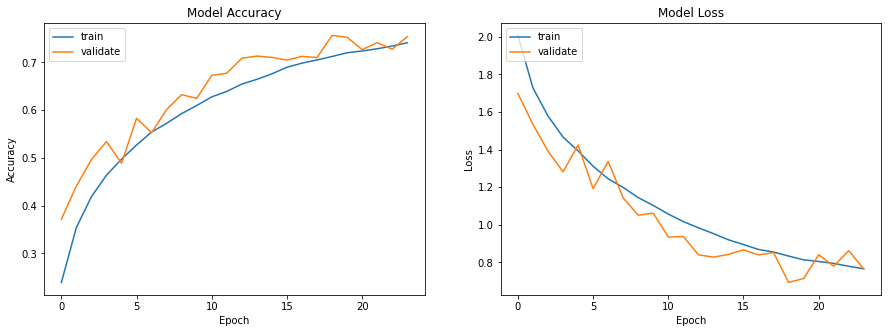

[([0.23906666040420532,
   0.3543555438518524,
   0.4187111258506775,
   0.4636666774749756,
   0.4973111152648926,
   0.5269777774810791,
   0.5540888905525208,
   0.5723333358764648,
   0.5927333235740662,
   0.6096444725990295,
   0.6277555823326111,
   0.6392222046852112,
   0.6545110940933228,
   0.6644666790962219,
   0.6759777665138245,
   0.6898444294929504,
   0.698377788066864,
   0.7051555514335632,
   0.7123110890388489,
   0.7201777696609497,
   0.7238888740539551,
   0.7284888625144958,
   0.734155535697937,
   0.7410222291946411],
  [0.37139999866485596,
   0.44119998812675476,
   0.49639999866485596,
   0.5342000126838684,
   0.4887999892234802,
   0.5827999711036682,
   0.5527999997138977,
   0.6014000177383423,
   0.6323999762535095,
   0.6245999932289124,
   0.6728000044822693,
   0.6772000193595886,
   0.7085999846458435,
   0.7131999731063843,
   0.7103999853134155,
   0.704800009727478,
   0.7125999927520752,
   0.7099999785423279,
   0.756600022315979,
   0.75260

In [ ]:
shift = 0.2
horizontal_flip = False
rotation = 0
workers = 4
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


### Shift=0.3, Flip=False, patience=5

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 37s 25ms/step - loss: 2.1587 - accuracy: 0.1781 - val_loss: 1.7869 - val_accuracy: 0.3316
Epoch 2/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.8450 - accuracy: 0.3008 - val_loss: 1.6179 - val_accuracy: 0.3914
Epoch 3/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.7129 - accuracy: 0.3613 - val_loss: 1.4679 - val_accuracy: 0.4618
Epoch 4/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.6098 - accuracy: 0.4053 - val_loss: 1.4011 - val_accuracy: 0.4918
Epoch 5/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.5303 - accuracy: 0.4419 - val_loss: 1.4195 - val_accuracy: 0.4792
Epoch 6/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.4496 - accuracy: 0.4726 - val_loss: 1.3178 - val_accuracy: 0.5396
Epoch 7/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.3899 - accuracy: 0.4967 - val_loss: 1

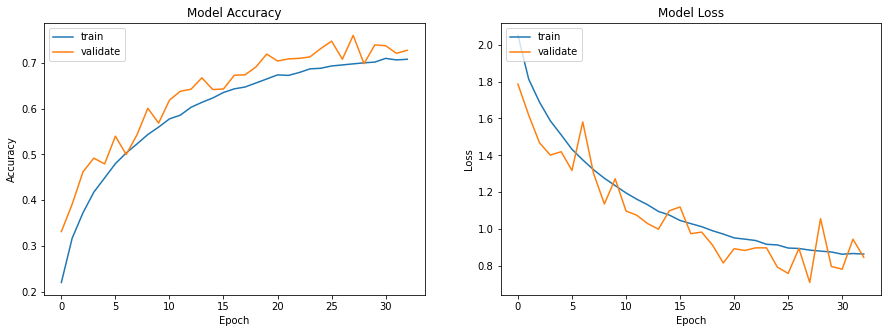

[([0.22064444422721863,
   0.31717777252197266,
   0.3725111186504364,
   0.41753333806991577,
   0.44851112365722656,
   0.47982221841812134,
   0.5030666589736938,
   0.5228222012519836,
   0.5433111190795898,
   0.5594888925552368,
   0.5773777961730957,
   0.5854889154434204,
   0.602733314037323,
   0.6133999824523926,
   0.6229333281517029,
   0.6349777579307556,
   0.6429111361503601,
   0.6469555497169495,
   0.6556888818740845,
   0.6644444465637207,
   0.6733777523040771,
   0.6722221970558167,
   0.6784889101982117,
   0.6864888668060303,
   0.6878222227096558,
   0.6928222179412842,
   0.695111095905304,
   0.6974444389343262,
   0.6996444463729858,
   0.7012888789176941,
   0.7093999981880188,
   0.7059999704360962,
   0.707444429397583],
  [0.33160001039505005,
   0.391400009393692,
   0.4618000090122223,
   0.4918000102043152,
   0.47920000553131104,
   0.5396000146865845,
   0.49959999322891235,
   0.5428000092506409,
   0.600600004196167,
   0.5681999921798706,
   0.61

In [ ]:
shift = 0.3
horizontal_flip = False
rotation = 0
workers = 4
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


### Shift=0.1, Flip=True, rotation=10

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 71s 27ms/step - loss: 2.1103 - accuracy: 0.1966 - val_loss: 1.6626 - val_accuracy: 0.3886
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.6837 - accuracy: 0.3745 - val_loss: 1.4647 - val_accuracy: 0.4648
Epoch 3/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.5112 - accuracy: 0.4434 - val_loss: 1.4401 - val_accuracy: 0.4894
Epoch 4/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.3756 - accuracy: 0.5030 - val_loss: 1.2458 - val_accuracy: 0.5528
Epoch 5/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.2842 - accuracy: 0.5388 - val_loss: 1.2453 - val_accuracy: 0.5706
Epoch 6/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.2104 - accuracy: 0.5708 - val_loss: 1.0491 - val_accuracy: 0.6224
Epoch 7/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.1309 - accuracy: 0.5986 - val_loss: 1

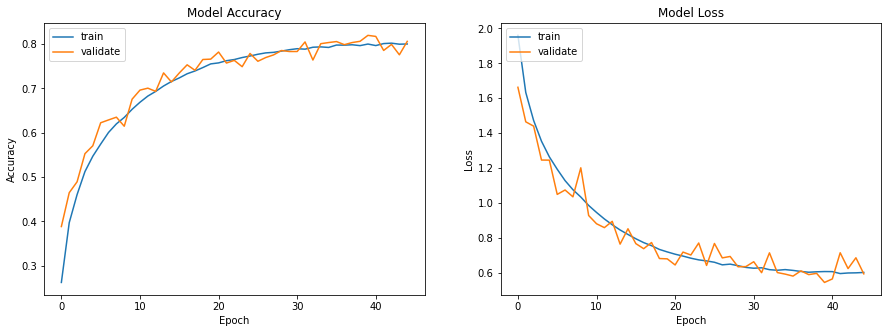

[([0.26260000467300415,
   0.3972666561603546,
   0.4605777859687805,
   0.5124444365501404,
   0.5470444560050964,
   0.5743555426597595,
   0.600600004196167,
   0.6199111342430115,
   0.6344444155693054,
   0.6527777910232544,
   0.6686444282531738,
   0.6825777888298035,
   0.6930888891220093,
   0.7052444219589233,
   0.715399980545044,
   0.7234888672828674,
   0.7328444719314575,
   0.739133358001709,
   0.746844470500946,
   0.7550888657569885,
   0.7573333382606506,
   0.7622666954994202,
   0.7649111151695251,
   0.7694000005722046,
   0.7728666663169861,
   0.7767999768257141,
   0.7798888683319092,
   0.7811111211776733,
   0.7839333415031433,
   0.7870444655418396,
   0.7893111109733582,
   0.788266658782959,
   0.7926222085952759,
   0.7934222221374512,
   0.7921555638313293,
   0.7975555658340454,
   0.7973333597183228,
   0.7981777787208557,
   0.7962666749954224,
   0.799822211265564,
   0.7963777780532837,
   0.8008666634559631,
   0.8017777800559998,
   0.79948890209

In [9]:
shift = 0.1
horizontal_flip = True
rotation = 10
workers = 4
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


### Shift=0.1, Flip=True, rotation=20

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 37s 26ms/step - loss: 2.1147 - accuracy: 0.1951 - val_loss: 1.7065 - val_accuracy: 0.3746
Epoch 2/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.6993 - accuracy: 0.3671 - val_loss: 1.4407 - val_accuracy: 0.4786
Epoch 3/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.5254 - accuracy: 0.4422 - val_loss: 1.3694 - val_accuracy: 0.5010
Epoch 4/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.3995 - accuracy: 0.4907 - val_loss: 1.2354 - val_accuracy: 0.5552
Epoch 5/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.3038 - accuracy: 0.5332 - val_loss: 1.2249 - val_accuracy: 0.5732
Epoch 6/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.2362 - accuracy: 0.5591 - val_loss: 1.0893 - val_accuracy: 0.6036
Epoch 7/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.1634 - accuracy: 0.5878 - val_loss: 1

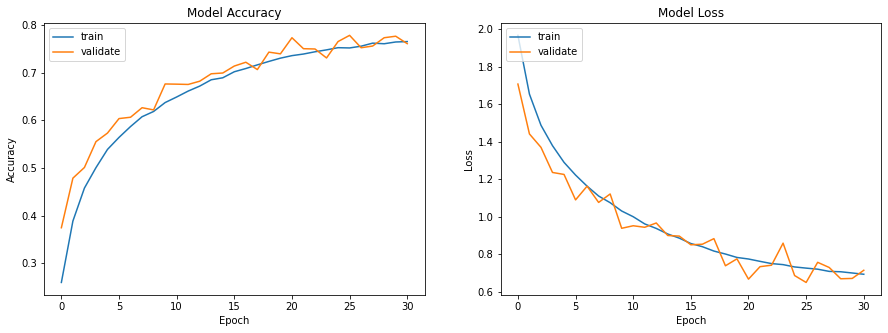

[([0.259799987077713,
   0.3885999917984009,
   0.4577777683734894,
   0.5005999803543091,
   0.5388666391372681,
   0.5640888810157776,
   0.5868889093399048,
   0.6074888706207275,
   0.6184889078140259,
   0.6371999979019165,
   0.648888885974884,
   0.6613110899925232,
   0.6717333197593689,
   0.685022234916687,
   0.6891777515411377,
   0.7018444538116455,
   0.7085999846458435,
   0.7162888646125793,
   0.7235110998153687,
   0.7303555607795715,
   0.7356444597244263,
   0.7390221953392029,
   0.7437333464622498,
   0.7477555274963379,
   0.7523333430290222,
   0.7517777681350708,
   0.755466639995575,
   0.7618666887283325,
   0.7605999708175659,
   0.7642889022827148,
   0.7651110887527466],
  [0.37459999322891235,
   0.47859999537467957,
   0.5009999871253967,
   0.5551999807357788,
   0.573199987411499,
   0.603600025177002,
   0.6064000129699707,
   0.6263999938964844,
   0.6218000054359436,
   0.6761999726295471,
   0.6758000254631042,
   0.6751999855041504,
   0.681999981

In [18]:
shift = 0.1
horizontal_flip = True
rotation = 20
workers = 4
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


### Shift=0.1, Flip=True, rotation=30

Model: "Bigger_CNN_3ConvBlocks_smaller_padding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1407/1407 [==============================] - 38s 26ms/step - loss: 2.1210 - accuracy: 0.1916 - val_loss: 1.6833 - val_accuracy: 0.3854
Epoch 2/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.7206 - accuracy: 0.3653 - val_loss: 1.4702 - val_accuracy: 0.4606
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.5666 - accuracy: 0.4269 - val_loss: 1.3806 - val_accuracy: 0.5000
Epoch 4/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.4482 - accuracy: 0.4766 - val_loss: 1.3263 - val_accuracy: 0.5206
Epoch 5/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.3542 - accuracy: 0.5100 - val_loss: 1.2735 - val_accuracy: 0.5612
Epoch 6/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.2923 - accuracy: 0.5381 - val_loss: 1.1341 - val_accuracy: 0.5882
Epoch 7/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1.2281 - accuracy: 0.5622 - val_loss: 1

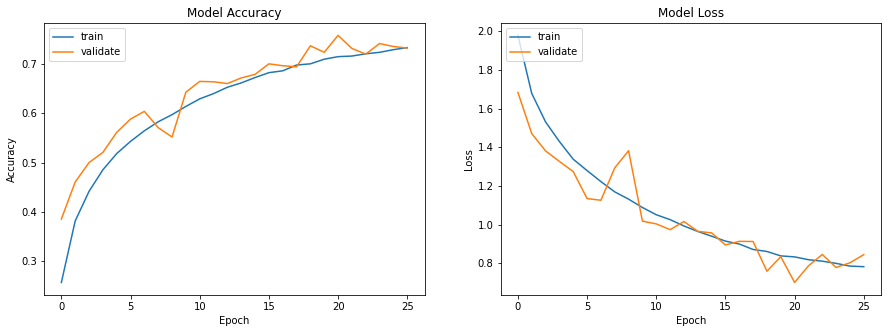

[([0.25679999589920044,
   0.38153332471847534,
   0.4415777921676636,
   0.4852444529533386,
   0.5182444453239441,
   0.5429555773735046,
   0.5644444227218628,
   0.5826888680458069,
   0.5971555709838867,
   0.6138444542884827,
   0.6291999816894531,
   0.639822244644165,
   0.652733325958252,
   0.6615555286407471,
   0.6724222302436829,
   0.6823111176490784,
   0.6860666871070862,
   0.6978222131729126,
   0.7002444267272949,
   0.7096222043037415,
   0.7148000001907349,
   0.7160221934318542,
   0.7205777764320374,
   0.7235555648803711,
   0.7289555668830872,
   0.7331555485725403],
  [0.3853999972343445,
   0.46059998869895935,
   0.5,
   0.5206000208854675,
   0.5612000226974487,
   0.5881999731063843,
   0.6037999987602234,
   0.5708000063896179,
   0.551800012588501,
   0.642799973487854,
   0.6646000146865845,
   0.6638000011444092,
   0.6601999998092651,
   0.6715999841690063,
   0.6787999868392944,
   0.7002000212669373,
   0.696399986743927,
   0.6941999793052673,
   0

In [27]:
shift = 0.1
horizontal_flip = True
rotation = 30
workers = 4
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

results_of_model(model, opt[0], opt[1], n=1, plot=True,
                 data_augmentation=data_augmentation, 
                 shift=shift, horizontal_flip=horizontal_flip, rotation=rotation,
                 workers=workers, early_stopping=early_stopping)


## Show results

In [28]:
directory = 'drive/MyDrive/Colab Notebooks/aug/'
files = os.listdir(directory)
files = [f for f in files if f != '.ipynb_checkpoints']
data = {'shift': [],
        'flip': [],
        'rotation': [],
        'patience': [],
        'acc': [],
        'loss': []}

for filename in files:
  name_list = filename.split('-')
  data['shift'].append(name_list[2])    
  data['flip'].append(name_list[3])    
  data['rotation'].append(name_list[4])    
  data['patience'].append(name_list[5])
  patience = int(name_list[5])
  with open(directory + filename, 'rb') as f:
    history = pickle.load(f)
    data['acc'].append(history[0][1][-(patience+1)])
    data['loss'].append(history[0][3][-(patience+1)])

print(pd.DataFrame(data))


   shift   flip rotation patience     acc      loss
0   0.05   True       10       10  0.8204  0.543532
1   0.05  False        0        5  0.7944  0.599158
2   0.05  False       10        5  0.7940  0.605099
3    0.1  False        0        5  0.8054  0.578993
4    0.2  False        0        5  0.7566  0.693522
5    0.3  False        0        5  0.7596  0.709871
6   0.05   True        0        5  0.8124  0.556036
7   0.05   True       10        5  0.7864  0.626210
8    0.1   True       10        5  0.8194  0.544744
9    0.1   True       20        5  0.7782  0.649305
10   0.1   True       30        5  0.7580  0.700390


# Save model


In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7468 - accuracy: 0.7694
Test loss: 0.7468319535255432
Test accuracy: 0.7694000005722046


In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model2.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model2.h5 
313/313 [==============================] - 2s 7ms/step - loss: 0.6198 - accuracy: 0.7879
Test loss: 0.619803786277771
Test accuracy: 0.7878999710083008


In [ ]:
y_pred = saved_model.predict_classes(X_test, verbose=0)

class_names = ['airplane',
                'automobile',
                'bird',
                'cat',
                'deer',
                'dog',
                'frog',
                'horse',
                'ship',
                'truck']
y_pred = [class_names[i] for i in y_pred]

submissions=pd.DataFrame({"id": list(range(1, len(y_pred)+1)),
                          "label": y_pred})

submissions.to_csv("submission.csv", index=False)

# Trained models
